In [407]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [454]:
df = pd.read_csv("train.csv")

Q1 = df.quantile(0.25, numeric_only=True)
Q3 = df.quantile(0.75, numeric_only=True)
IQS = Q3 - Q1

outliers = ((df[IQS.index] < Q1 - 1.5*IQS) | (df[IQS.index] > Q3 + 1.5*IQS)).any(axis=1)
df = df[~outliers]

df1 = pd.read_csv("test.csv")
df2 = pd.concat([df, df1])
df2.reset_index(inplace=True, drop=True)

In [455]:
df2['MSSubClass'] = df2['MSSubClass'].astype("category")
df2['MoSold'] = df2['MoSold'].astype("category")

In [456]:
quality_nans = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                'GarageCond','KitchenQual',  'PoolQC', 'Fence']

for col in quality_nans:
    df2[col] = df2[col].fillna("None")

In [457]:
df2['MSZoning'] = df2['MSZoning'].fillna(df2.groupby(['MSSubClass','Neighborhood'])['MSZoning'].transform(lambda x: x.mode()[0]))
df2['MasVnrType'] = df2['MasVnrType'].fillna(df2.groupby(['MSSubClass','Neighborhood'])['MasVnrType'].transform(lambda x: x.mode()[0]))
df2['Electrical'] = df2['Electrical'].fillna(df2.groupby(['MSSubClass','Neighborhood'])['Electrical'].transform(lambda x: x.mode()[0]))
df2['Utilities'] = df2['Utilities'].fillna(df2.groupby(['MSSubClass','Neighborhood'])['Utilities'].transform(lambda x: x.mode()[0]))
df2['Exterior1st'] = df2['Exterior1st'].fillna(df2.groupby(['MSSubClass','Neighborhood'])['Exterior1st'].transform(lambda x: x.mode()[0]))
df2['Exterior2nd'] = df2['Exterior2nd'].fillna(df2.groupby(['MSSubClass','Neighborhood'])['Exterior2nd'].transform(lambda x: x.mode()[0]))
df2['Functional'] = df2['Functional'].fillna(df2.groupby(['MSSubClass','Neighborhood'])['Functional'].transform(lambda x: x.mode()[0]))
df2['SaleType'] = df2['Functional'].fillna(df2.groupby('SaleCondition')['Functional'].transform(lambda x: x.mode()[0]))


df2['LotFrontage'] = df2['LotFrontage'].fillna(df2.groupby('LotShape')['LotFrontage'].transform('mean'))
df2['BsmtFinSF1'] = df2['BsmtFinSF1'].fillna(df2.groupby('BsmtFinType1')['BsmtFinSF1'].transform('mean'))
df2['BsmtFinSF2'] = df2['BsmtFinSF2'].fillna(df2.groupby('BsmtFinType2')['BsmtFinSF2'].transform('mean'))
df2['BsmtUnfSF'] = df2['BsmtUnfSF'].fillna(df2.groupby('BsmtQual')['BsmtUnfSF'].transform('mean'))
df2['MasVnrArea'] = df2['MasVnrArea'].fillna(df2.groupby('Neighborhood')['MasVnrArea'].transform('mean'))
df2['TotalBsmtSF'] = df2['TotalBsmtSF'].fillna(df2.groupby('BsmtFinType1')['TotalBsmtSF'].transform('mean'))

df2['BsmtFullBath'].fillna(0., inplace=True)
df2['BsmtHalfBath'].fillna(0., inplace=True)
df2['GarageCars'].fillna(0., inplace=True)
df2['GarageArea'].fillna(0., inplace=True)
df2['GarageYrBlt'].fillna(0, inplace=True)

In [458]:
df2['TotalArea'] = df2['TotalBsmtSF'] + df2['1stFlrSF'] + df2['2ndFlrSF'] + df2['GrLivArea'] + df2['GarageArea']
df2['Bathrooms'] = df2['FullBath'] + df2['HalfBath']/2 + df2['BsmtFullBath'] + df['BsmtHalfBath']/2
df2['Year average']= (df2['YearRemodAdd'] + df2['YearBuilt']) /2

df2.drop(columns=['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
                 'GarageArea', 'Alley', 'MiscFeature'],#, 'FullBath', 'HalfBath'],
        inplace=True)

In [459]:
df_dummies = pd.get_dummies(df2)

In [461]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = df_dummies.drop(columns=['Id', 'SalePrice']).iloc[:len(df)]
y = df['SalePrice'].iloc[:len(df)]

X_test = df_dummies.drop(columns=['Id', 'SalePrice']).iloc[len(df):]
Id_test = df_dummies['Id'].iloc[len(df):]

Scaler = StandardScaler()
Scaler.fit(X)

features = X.columns.values
#X = Scaler.transform(X)
#X = pd.DataFrame(X, columns = features)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

<Axes: >

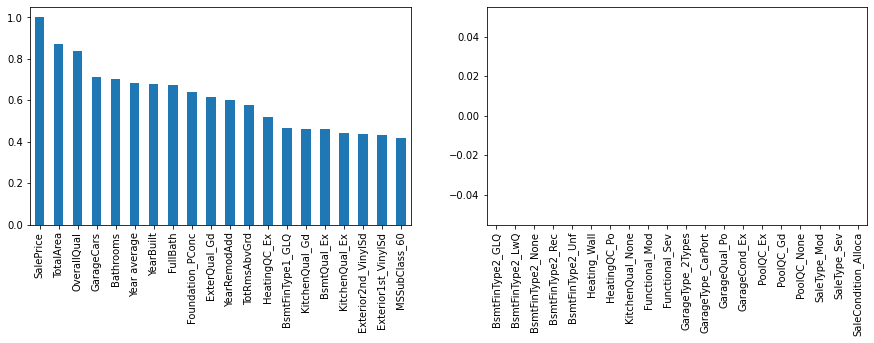

In [462]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
df_dummies.corr()['SalePrice'].sort_values(ascending=False)[:20].plot.bar(ax=axes[0])
df_dummies.corr()['SalePrice'].sort_values(ascending=False)[-20:].plot.bar(ax=axes[1])

In [463]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

print("Training Error: ", model.score(X_train, y_train))
print("Test Error: ", model.score(X_valid, y_valid))

Training Error:  0.9999919111536223
Test Error:  0.9357258824669528


In [464]:
y_pred = model.predict(X_valid)
metrics.mean_squared_error(y_valid, y_pred)

196454490.16018555

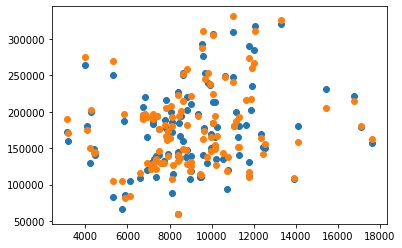

In [468]:
plt.scatter(X_valid['LotArea'], y_valid)
plt.scatter(X_valid['LotArea'], y_pred)

In [466]:
y_test = model.predict(X_test)

In [475]:
result = pd.DataFrame({"Id":Id_test, "SalePrice":y_test})
result.to_csv("submission.csv", index=False)

In [474]:
Id_test

563     1461
564     1462
565     1463
566     1464
567     1465
        ... 
2017    2915
2018    2916
2019    2917
2020    2918
2021    2919
Name: Id, Length: 1459, dtype: int64